In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import warnings
import pickle
from sklearn.model_selection import GridSearchCV
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Step 1**

## OLS on PD

In [3]:
data = pd.read_excel('../dataproject2024.xlsx')
data.head()

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0


In [63]:
# Scale continuous variables to have a meaningful comparison of the coefficients
continuous_features = ['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration','Monthly payment']
categorical_features = ['Down payment', 'Credit event', 'Married', 'Homeowner']

model = LinearRegression()

# Scale continuous features, include categorical features, drop the remaining columns
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), continuous_features),
    ('cat','passthrough',categorical_features)
],
remainder='drop')

# Fit a linear regression with 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),        
    ('regression', model)    
])


y = data['PD']

# Split data between test and train
X_train, X_test, y_train, y_test = train_test_split(data,y)

# Fit the regressor
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Compute the RMSE
rmse = root_mean_squared_error(y_pred,y_test)
rmse

np.float64(0.15353914583891987)

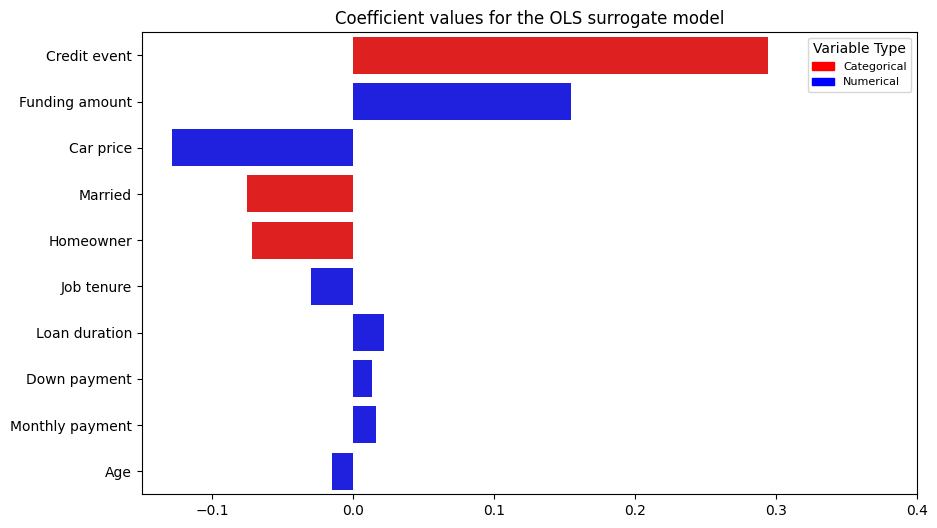

In [64]:
# Retrieve the coefficient values and feature names
coefficients = pipeline.named_steps['regression'].coef_
features = continuous_features + categorical_features

# Colorize the categorical features in red, numerical ones in blue
colors = ['blue' for i in continuous_features] + ['red' for i in categorical_features]

# Plot the coefficient values for each feature
plt.figure(figsize=(10, 6))

features_and_coeff = zip(features,coefficients,colors)
features_and_coeff_ranked = sorted(features_and_coeff, key=lambda x: abs(x[1]),reverse=True)
ranked_features, ranked_coefficients, ranked_colors = zip(*features_and_coeff_ranked)

sns.barplot(x=ranked_coefficients, y=ranked_features, palette=ranked_colors, ci=None, legend=False)
plt.title("Coefficient values for the OLS surrogate model")
plt.xticks([-0.1,0.0,0.1,0.2,0.3,0.4])

# Add colors to legend
red_patch = mpatches.Patch(color='red', label='Categorical')
blue_patch = mpatches.Patch(color='blue', label='Numerical')
plt.legend(handles=[red_patch, blue_patch], title='Variable Type',fontsize=8)

# Display the plot
plt.show()

## Logistic regression

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
data = pd.read_excel('../dataproject2024.xlsx')
data.head()

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0


In [66]:
# We are going to fit a classifier on the y_hat predicted by the black box model
y = data['Pred_default (y_hat)']

# Split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(data, y)


# Scale continuous variables to have a meaningful comparison of the coefficients
continuous_features = ['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration','Monthly payment']
categorical_features = ['Down payment', 'Credit event', 'Married', 'Homeowner']

model = LogisticRegression(penalty='l2')

# Scale continuous features, include categorical features, drop the remaining columns
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), continuous_features),
    ('cat','passthrough',categorical_features)
],
remainder='drop')

# Fit a linear regression with 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),        
    ('log_regression', model)    
])

# Split data between test and train
X_train, X_test, y_train, y_test = train_test_split(data,y)

# Fit the regressor
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"""Our model has:
      - an accuracy on the test set of {accuracy} 
      - a balanced accuracy of {balanced_accuracy}
      - an auc of {auc}""")

Our model has:
      - an accuracy on the test set of 0.9068891280947255 
      - a balanced accuracy of 0.6408964424846954
      - an auc of 0.6408964424846955


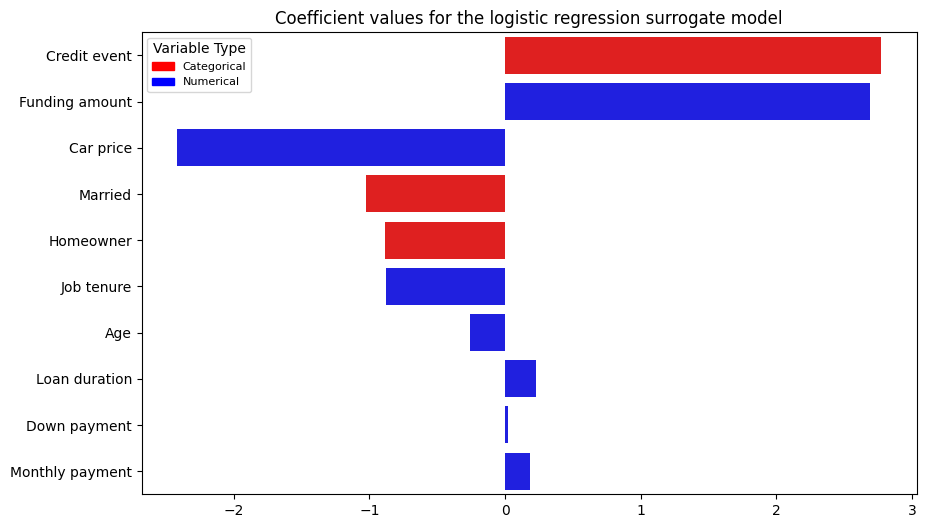

In [70]:
# Retrieve the coefficient values and feature names
coefficients = pipeline.named_steps['log_regression'].coef_.ravel() 
features = continuous_features + categorical_features

# Colorize the categorical features in red, numerical ones in blue
colors = ['blue' for i in continuous_features] + ['red' for i in categorical_features]

# Plot the coefficient values for each feature
plt.figure(figsize=(10, 6))

features_and_coeff = zip(features,coefficients,colors)
features_and_coeff_ranked = sorted(features_and_coeff, key=lambda x: abs(x[1]),reverse=True)
ranked_features, ranked_coefficients, ranked_colors = zip(*features_and_coeff_ranked)

sns.barplot(x=ranked_coefficients, y=ranked_features, palette=ranked_colors, ci=None, legend=False)
plt.title("Coefficient values for the logistic regression surrogate model")

# Add colors to legend
red_patch = mpatches.Patch(color='red', label='Categorical')
blue_patch = mpatches.Patch(color='blue', label='Numerical')
plt.legend(handles=[red_patch, blue_patch], title='Variable Type',fontsize=8)

# Display the plot
plt.show()

# **Step 2**

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
data = pd.read_excel('../dataproject2024.xlsx')
data.head()

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0


In [7]:
X = data.drop(columns=['ID', 'Default (y)', 'Pred_default (y_hat)','PD','Group'])
y = data['Default (y)']
X.head()

,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner
0,34,55,4875,3087,0,36,0.047895,0,1,1
1,5,29,13000,13000,0,60,0.091667,0,0,0
2,14,38,17190,14190,0,60,0.088235,0,0,0
3,16,37,22773,23568,0,48,0.110084,0,1,1
4,1,61,7700,8526,0,48,0.123404,0,1,0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"The AUC is {auc}")

The AUC is 0.7742378162532465


In [21]:
param_grid = {
    'n_estimators': [100,150,200],
    'max_depth' : [5,10,20],
    'min_samples_split': [3, 5, 10], 
    'min_samples_leaf': [2, 3, 5]
}

In [22]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=4, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=3, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

The best model is RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10)

In [24]:
best_rf = grid_search.best_estimator_
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"The AUC of our final blackbox model is {auc}")

The AUC of our final blackbox model is 0.7774356118309336


In [26]:
pickle.dump(best_rf, open('fitted_bb_model.pkl','wb'))

In [32]:
model = pickle.load(open("../fitted_bb_model.pkl",'rb'))

In [33]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])